In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor_PM, MORCGP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

In [36]:
introduce_outliers = True
introduce_missing_values = True

run_mogp = False
run_pm = True
run_morcgp = True

rmses_mogp_outliers, rmses_morcgp_outliers, rmses_pm_outliers = [], [], []
nlpds_mogp_outliers, nlpds_morcgp_outliers, nlpds_pm_outliers = [], [], []

N, D = 100, 3
noise_var = 0.1
if introduce_outliers:
    epsilon = 0.1
else:
    epsilon = 0

if introduce_missing_values:
    missing_rate = 0.0
else:
    missing_rate = 0

lengthscale = 1
rbf_variance = 1.0

# B = np.array([
#     [1.0,  0.9,  0.7,  0.5],
#     [0.9,  1.0,  0.8,  0.6],
#     [0.7, 0.8,  1.0, 0.9],
#     [0.5,  0.6,  0.9,  1.0],
# ])
B = np.array([
    [1.0,  0.9,  0.7],
    [0.9,  1.0,  0.8],
    [0.7, 0.8,  1.0],
])
A = np.linalg.cholesky(B)

epsilons = np.array([epsilon] * D)

for i in tqdm(range(11,12)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*N), lower=True)

    f_samples = L @ np.random.randn(D*N)
    F = f_samples.reshape(D, N).T
    Y_test = F + np.random.normal(0, noise_var, F.shape)
    Y_train = Y_test.copy()

    outliers_mask = np.zeros_like(Y_train, dtype=bool)

    # Introduce missing values
    if introduce_missing_values:
        n_missing = int(missing_rate * Y_train.size)
        missing_indices = np.random.choice(Y_train.size, n_missing, replace=False)
        missing_coords = np.unravel_index(missing_indices, Y_train.shape)
        Y_train[missing_coords] = np.nan

    # Introduce outliers
    if introduce_outliers:
        for col in range(D):
            non_nan_rows = np.where(~np.isnan(Y_train[:, col]))[0]
            n_non_nan = len(non_nan_rows)
            num_outliers = int(epsilon * n_non_nan)
            if num_outliers > 0:
                outlier_rows = np.random.choice(non_nan_rows, num_outliers, replace=False)

                for row in outlier_rows:
                    if Y_train[row, col] > 0:
                        Y_train[row, col] += np.random.uniform(-3, -2)  # negative outlier
                    else:
                        Y_train[row, col] += np.random.uniform(2, 3)    # positive outlier
                outliers_mask[outlier_rows, col] = True

        # Count outliers per column
        outliers_per_column = np.sum(outliers_mask, axis=0)
        
    Y_train_clean = Y_train[~np.isnan(Y_train).any(axis=1)]
    mcd = MinCovDet(support_fraction=1-2*epsilon).fit(Y_train_clean)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    if run_mogp:
        # MOGP
        mogp = MOGPRegressor(mean=0, length_scale=1, noise = np.array([0.1] * D), A = robust_init_A)
        mogp.fit(x, Y_train)
        mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
        mu_mogp, var_mogp = mogp.predict(x)
        std_mogp = np.sqrt(var_mogp + mogp.noise)

    if run_morcgp:
        # MORCGP   
        morcgp = MORCGP(mean=0, length_scale=1, noise_var=np.array([0.1]*D), A=robust_init_A)
        morcgp.fit(x, Y_train, epsilons=np.array([0.2]*D))
        init_gamma, init_c, gamma, c = morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
        mu_morcgp, var_morcgp = morcgp.predict(x)
        std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

    if run_pm:
        # MORCGP (RCGP weights)
        morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=1, noise=np.array([0.1]*D), A=robust_init_A, epsilons=epsilons)
        morcgp_pm.fit(x, Y_train)
        morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)
        mu_pm, var_pm = morcgp_pm.predict(x)
        std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # Performance metrics
    if run_mogp:
        rmse_mogp = calculate_rmse(Y_test, mu_mogp)
        nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
        print(f'MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}')

        rmses_mogp_outliers.append(rmse_mogp)
        nlpds_mogp_outliers.append(nlpd_mogp)

    if run_pm:
        rmse_pm = calculate_rmse(Y_test, mu_pm)
        nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)
        print(f'MORCGP PM seed {i}: RMSE = {rmse_pm}, NLPD = {nlpd_pm}')

        rmses_pm_outliers.append(rmse_pm)
        nlpds_pm_outliers.append(nlpd_pm)

    if run_morcgp:
        rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
        nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
        print(f'MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}')

        rmses_morcgp_outliers.append(rmse_morcgp)
        nlpds_morcgp_outliers.append(nlpd_morcgp)

if run_mogp:
    print(f'RMSE MOGP: {np.mean(rmses_mogp_outliers):.4f} ± {np.std(rmses_mogp_outliers):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp_outliers):.4f} ± {np.std(nlpds_mogp_outliers):.4f}')
if run_pm:
    print(f'RMSE MORCGP (PM): {np.mean(rmses_pm_outliers):.4f} ± {np.std(rmses_pm_outliers):.4f}')
    print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm_outliers):.4f} ± {np.std(nlpds_pm_outliers):.4f}')
if run_morcgp:
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp_outliers):.4f} ± {np.std(rmses_morcgp_outliers):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp_outliers):.4f} ± {np.std(nlpds_morcgp_outliers):.4f}')

100%|██████████| 1/1 [01:17<00:00, 77.09s/it]

MORCGP PM seed 11: RMSE = 0.206396829623943, NLPD = 0.31397014293898584
MORCGP seed 11: RMSE = 0.12235440406595431, NLPD = 0.19797564851435911
RMSE MORCGP (PM): 0.2064 ± 0.0000
NLPD MORCGP (PM): 0.3140 ± 0.0000
RMSE MORCGP: 0.1224 ± 0.0000
NLPD MORCGP: 0.1980 ± 0.0000


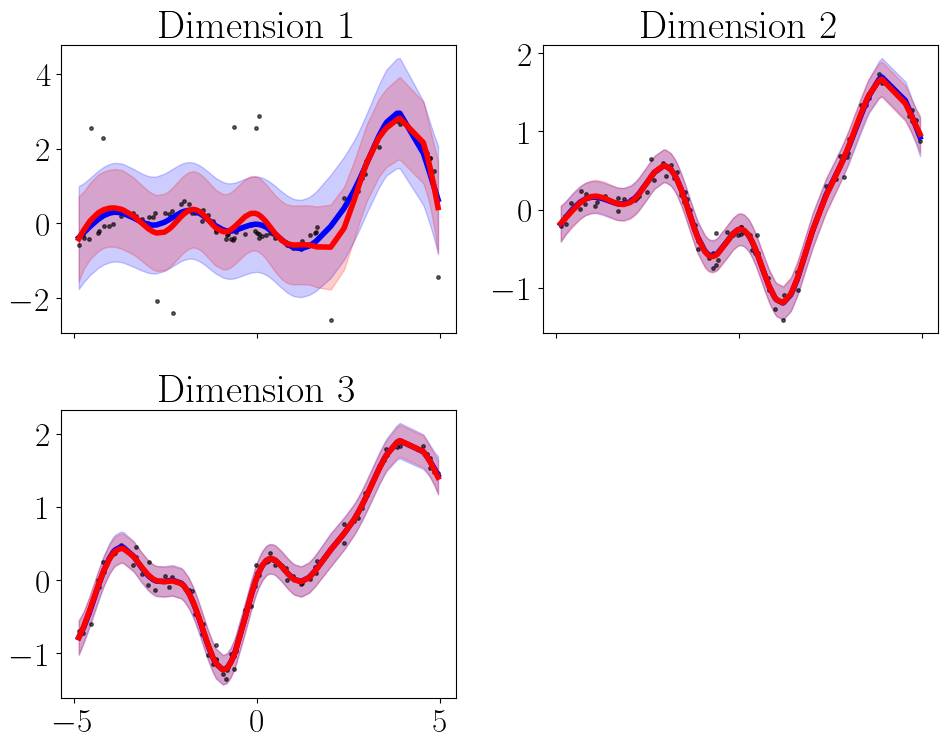

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Assume:
# x: (N, 1)
# Y: (N, D)
# mu_pm, std_pm, mu_morcgp, std_morcgp: (N, D)

x_flat = x.flatten()
D = Y_train.shape[1]

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()  # make it easier to iterate

for d in range(min(D, 4)):  # plot up to 4 dimensions
    ax = axes[d]
    
    # Scatter of data
    ax.plot(x_flat, Y_train[:, d], 'k.', label='Data', alpha=0.6)
    
    # PM predictions
    ax.plot(x_flat, mu_pm[:, d], 'b-', label='PM mean')
    ax.fill_between(
        x_flat,
        mu_pm[:, d] - 2 * std_pm[:, d],
        mu_pm[:, d] + 2 * std_pm[:, d],
        color='b',
        alpha=0.2,
        label='PM ±2 std'
    )

    # ax.fill_between(
    #     x_flat,
    #     - morcgp_pm.cs.reshape(D,N).T[:, d],
    #     morcgp_pm.cs.reshape(D,N).T[:, d],
    #     color='b',
    #     alpha=0.2,
    #     label='PM ±2 std'
    # )
    
    # MORCGP predictions
    ax.plot(x_flat, mu_morcgp[:, d], 'r-', label='MORCGP mean')
    ax.fill_between(
        x_flat,
        mu_morcgp[:, d] - 2 * std_morcgp[:, d],
        mu_morcgp[:, d] + 2 * std_morcgp[:, d],
        color='r',
        alpha=0.2,
        label='MORCGP ±2 std'
    )

    # ax.plot(x_flat, gamma[:, d], 'r-', label='MORCGP mean')
    # ax.fill_between(
    #     x_flat,
    #     gamma[:, d] - c[:, d],
    #     gamma[:, d] + c[:, d],
    #     color='r',
    #     alpha=0.2,
    #     label='MORCGP ±2 std'
    # )

    # ax.plot(x_flat, init_gamma[:, d], 'r-', label='MORCGP mean')
    # ax.fill_between(
    #     x_flat,
    #     init_gamma[:, d] - init_c[:, d],
    #     init_gamma[:, d] + init_c[:, d],
    #     color='r',
    #     alpha=0.2,
    #     label='MORCGP ±2 std'
    # )
    
    ax.set_title(f'Dimension {d+1}')
    # ax.legend(fontsize=8)
    # ax.grid(True)

# Hide any unused subplots
for i in range(min(D, 4), 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [46]:
robust_covariance

array([[0.13188262, 0.14858754, 0.06737398],
       [0.14858754, 0.25223364, 0.06161908],
       [0.06737398, 0.06161908, 0.29001317]])

In [53]:
introduce_outliers = False
introduce_missing_values = False

run_mogp = True
run_pm = True
run_morcgp = True

rmses_mogp_outliers, rmses_morcgp_outliers, rmses_pm_outliers = [], [], []
nlpds_mogp_outliers, nlpds_morcgp_outliers, nlpds_pm_outliers = [], [], []

N, D = 100, 3
noise_var = 0.1
if introduce_outliers:
    epsilon = 0.1
else:
    epsilon = 0

if introduce_missing_values:
    missing_rate = 0.1
else:
    missing_rate = 0

lengthscale = 1
rbf_variance = 1.0

# B = np.array([
#     [1.0,  0.9,  0.7,  0.5],
#     [0.9,  1.0,  0.8,  0.6],
#     [0.7, 0.8,  1.0, 0.9],
#     [0.5,  0.6,  0.9,  1.0],
# ])
B = np.array([
    [1.0,  0.9,  0.7],
    [0.9,  1.0,  0.8],
    [0.7, 0.8,  1.0],
])
A = np.linalg.cholesky(B)

epsilons = np.array([epsilon, 0, 0])

for i in tqdm(range(20)):
    np.random.seed(i)
    x = np.sort(np.random.uniform(-5, 5, N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    L = cholesky(K + 1e-6*np.eye(D*N), lower=True)

    f_samples = L @ np.random.randn(D*N)
    F = f_samples.reshape(D, N).T
    Y_test = F + np.random.normal(0, noise_var, F.shape)
    Y_train = Y_test.copy()

    outliers_mask = np.zeros_like(Y_train, dtype=bool)

    # Introduce missing values
    if introduce_missing_values:
        n_missing = int(missing_rate * Y_train.size)
        missing_indices = np.random.choice(Y_train.size, n_missing, replace=False)
        missing_coords = np.unravel_index(missing_indices, Y_train.shape)
        Y_train[missing_coords] = np.nan

    # Introduce outliers in only one column (e.g., first column)
    if introduce_outliers:
        target_col = 0  # change this index to select which column (0-based)
        non_nan_rows = np.where(~np.isnan(Y_train[:, target_col]))[0]
        n_non_nan = len(non_nan_rows)
        num_outliers = int(epsilon * n_non_nan)

        if num_outliers > 0:
            outlier_rows = np.random.choice(non_nan_rows, num_outliers, replace=False)

            for row in outlier_rows:
                if Y_train[row, target_col] > 0:
                    Y_train[row, target_col] += np.random.uniform(-3, -2)  # negative outlier
                else:
                    Y_train[row, target_col] += np.random.uniform(2, 3)    # positive outlier
            outliers_mask[outlier_rows, target_col] = True

        # Count outliers in that column
        outliers_per_column = np.sum(outliers_mask, axis=0)
        
    Y_train_clean = Y_train[~np.isnan(Y_train).any(axis=1)]
    mcd = MinCovDet(support_fraction=1-2*epsilon).fit(Y_train_clean)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    if run_mogp:
        # MOGP
        mogp = MOGPRegressor(mean=0, length_scale=1, noise = np.array([0.1] * D), A = robust_init_A)
        mogp.fit(x, Y_train)
        mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
        mu_mogp, var_mogp = mogp.predict(x)
        std_mogp = np.sqrt(var_mogp + mogp.noise)

    if run_morcgp:
        # MORCGP   
        morcgp = MORCGP(mean=0, length_scale=1, noise_var=np.array([0.1]*D), A=robust_init_A)
        morcgp.fit(x, Y_train, epsilons=epsilons)
        init_gamma, init_c, gamma, c = morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
        mu_morcgp, var_morcgp = morcgp.predict(x)
        std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

    if run_pm:
        # MORCGP (RCGP weights)
        morcgp_pm = MORCGPRegressor_PM(mean=0, length_scale=1, noise=np.array([0.1]*D), A=robust_init_A, epsilons=epsilons)
        morcgp_pm.fit(x, Y_train)
        morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False)
        mu_pm, var_pm = morcgp_pm.predict(x)
        std_pm = np.sqrt(var_pm + morcgp_pm.noise)

    # Performance metrics
    if run_mogp:
        rmse_mogp = calculate_rmse(Y_test, mu_mogp)
        nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
        print(f'MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}')

        rmses_mogp_outliers.append(rmse_mogp)
        nlpds_mogp_outliers.append(nlpd_mogp)

    if run_pm:
        rmse_pm = calculate_rmse(Y_test, mu_pm)
        nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)
        print(f'MORCGP PM seed {i}: RMSE = {rmse_pm}, NLPD = {nlpd_pm}')

        rmses_pm_outliers.append(rmse_pm)
        nlpds_pm_outliers.append(nlpd_pm)

    if run_morcgp:
        rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
        nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
        print(f'MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}')

        rmses_morcgp_outliers.append(rmse_morcgp)
        nlpds_morcgp_outliers.append(nlpd_morcgp)

if run_mogp:
    print(f'RMSE MOGP: {np.mean(rmses_mogp_outliers):.4f} ± {np.std(rmses_mogp_outliers):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp_outliers):.4f} ± {np.std(nlpds_mogp_outliers):.4f}')
if run_pm:
    print(f'RMSE MORCGP (PM): {np.mean(rmses_pm_outliers):.4f} ± {np.std(rmses_pm_outliers):.4f}')
    print(f'NLPD MORCGP (PM): {np.mean(nlpds_pm_outliers):.4f} ± {np.std(nlpds_pm_outliers):.4f}')
if run_morcgp:
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp_outliers):.4f} ± {np.std(rmses_morcgp_outliers):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp_outliers):.4f} ± {np.std(nlpds_morcgp_outliers):.4f}')

  5%|▌         | 1/20 [01:58<37:35, 118.72s/it]

MOGP seed 0: RMSE = 0.09364749930292234, NLPD = -0.9342706906141419
MORCGP PM seed 0: RMSE = 0.0924945373576198, NLPD = -0.9479313278652279
MORCGP seed 0: RMSE = 0.09336603595626772, NLPD = -0.9355558816792192


 10%|█         | 2/20 [05:33<52:32, 175.16s/it]

MOGP seed 1: RMSE = 0.09744857805814422, NLPD = -0.9014647266118097
MORCGP PM seed 1: RMSE = 0.0959239059466278, NLPD = -0.9198470379665573
MORCGP seed 1: RMSE = 0.09717964124736268, NLPD = -0.9070533727867284


 15%|█▌        | 3/20 [06:46<36:24, 128.49s/it]

MOGP seed 2: RMSE = 0.09346435608879108, NLPD = -0.9310891331045035
MORCGP PM seed 2: RMSE = 0.09388081187247133, NLPD = -0.9112271603348767
MORCGP seed 2: RMSE = 0.09435269586858878, NLPD = -0.9291721640752544


 20%|██        | 4/20 [11:48<52:30, 196.93s/it]

MOGP seed 3: RMSE = 0.09069355487433683, NLPD = -0.9694019160215613
MORCGP PM seed 3: RMSE = 0.09043779784509262, NLPD = -0.9672480769164722
MORCGP seed 3: RMSE = 0.09204105419611039, NLPD = -0.9615515576721151


 25%|██▌       | 5/20 [13:53<42:47, 171.19s/it]

MOGP seed 4: RMSE = 0.08839123783691735, NLPD = -1.0003467097539998
MORCGP PM seed 4: RMSE = 0.08748823635955946, NLPD = -1.0067550613881557
MORCGP seed 4: RMSE = 0.08915907942089449, NLPD = -0.997413769141711


 30%|███       | 6/20 [15:52<35:45, 153.28s/it]

MOGP seed 5: RMSE = 0.08850906196262068, NLPD = -0.9910941974303746
MORCGP PM seed 5: RMSE = 0.08364934805864074, NLPD = -1.0270191267174102
MORCGP seed 5: RMSE = 0.08917553487678018, NLPD = -0.9886269611423033


 35%|███▌      | 7/20 [21:46<47:26, 218.94s/it]

MOGP seed 6: RMSE = 0.09190469461187896, NLPD = -0.9511932006510877
MORCGP PM seed 6: RMSE = 0.09203755253218779, NLPD = -0.9505679262050452
MORCGP seed 6: RMSE = 0.09155600059366184, NLPD = -0.9591784371537434


 40%|████      | 8/20 [25:40<44:45, 223.79s/it]

MOGP seed 7: RMSE = 0.08999914237780898, NLPD = -0.972211016961492
MORCGP PM seed 7: RMSE = 0.09020371715640207, NLPD = -0.9696738919636827
MORCGP seed 7: RMSE = 0.08785036538766887, NLPD = -0.9940496502136451


 45%|████▌     | 9/20 [29:42<42:05, 229.58s/it]

MOGP seed 8: RMSE = 0.0967583479731979, NLPD = -0.9045512524688771
MORCGP PM seed 8: RMSE = 0.09545451493817671, NLPD = -0.9155150445021915
MORCGP seed 8: RMSE = 0.09777603835539017, NLPD = -0.89848784868954


 50%|█████     | 10/20 [33:19<37:35, 225.59s/it]

MOGP seed 9: RMSE = 0.10324066305408161, NLPD = -0.8417543531234108
MORCGP PM seed 9: RMSE = 0.10322582344625301, NLPD = -0.8417459321342934
MORCGP seed 9: RMSE = 0.10014835380172432, NLPD = -0.8748015398872027


 55%|█████▌    | 11/20 [34:40<27:13, 181.47s/it]

MOGP seed 10: RMSE = 0.08639135556981226, NLPD = -1.0151608565725114
MORCGP PM seed 10: RMSE = 0.08799323237490052, NLPD = -0.9985344023543039
MORCGP seed 10: RMSE = 0.08638822632289289, NLPD = -1.0207268293332674


 60%|██████    | 12/20 [35:27<18:42, 140.35s/it]

MOGP seed 11: RMSE = 0.0922130303827657, NLPD = -0.9491067362554588
MORCGP PM seed 11: RMSE = 0.09201123197987153, NLPD = -0.9477051835589279
MORCGP seed 11: RMSE = 0.09310037572508705, NLPD = -0.9453398344783522


 65%|██████▌   | 13/20 [36:13<13:03, 111.86s/it]

MOGP seed 12: RMSE = 0.0937814281562159, NLPD = -0.9385251465306915
MORCGP PM seed 12: RMSE = 0.0939444598703764, NLPD = -0.9344069024855499
MORCGP seed 12: RMSE = 0.09385561256892333, NLPD = -0.9362213082204046


 70%|███████   | 14/20 [37:06<09:24, 94.13s/it] 

MOGP seed 13: RMSE = 0.09108261827602972, NLPD = -0.9638111981976573
MORCGP PM seed 13: RMSE = 0.08935623355595544, NLPD = -0.9830713190112373
MORCGP seed 13: RMSE = 0.09009498774047135, NLPD = -0.97506324002741


 75%|███████▌  | 15/20 [37:44<06:26, 77.28s/it]

MOGP seed 14: RMSE = 0.09541039233838076, NLPD = -0.9209515917381881
MORCGP PM seed 14: RMSE = 0.09539901746103531, NLPD = -0.906459216240202
MORCGP seed 14: RMSE = 0.09547017282130665, NLPD = -0.9199818912643


 80%|████████  | 16/20 [38:49<04:54, 73.52s/it]

MOGP seed 15: RMSE = 0.09415563235818321, NLPD = -0.9310375027386883
MORCGP PM seed 15: RMSE = 0.09430841711030676, NLPD = -0.9270166689165372
MORCGP seed 15: RMSE = 0.09528462716956536, NLPD = -0.923265734163297


 85%|████████▌ | 17/20 [40:06<03:43, 74.38s/it]

MOGP seed 16: RMSE = 0.09022036624101094, NLPD = -0.9869866007933313
MORCGP PM seed 16: RMSE = 0.08921930057903278, NLPD = -0.9932946222024933
MORCGP seed 16: RMSE = 0.09154280451955521, NLPD = -0.9801354269635999


 90%|█████████ | 18/20 [40:48<02:09, 64.72s/it]

MOGP seed 17: RMSE = 0.09643745737276226, NLPD = -0.9061829708752672
MORCGP PM seed 17: RMSE = 0.097495165143493, NLPD = -0.8850708099859708
MORCGP seed 17: RMSE = 0.09690048707544255, NLPD = -0.9065078246499303


 95%|█████████▌| 19/20 [41:32<00:58, 58.62s/it]

MOGP seed 18: RMSE = 0.09413747814765816, NLPD = -0.9306433011537756
MORCGP PM seed 18: RMSE = 0.09382687029040747, NLPD = -0.9295646179700515
MORCGP seed 18: RMSE = 0.09418522424910906, NLPD = -0.9326141203026367


100%|██████████| 20/20 [43:12<00:00, 129.64s/it]

MOGP seed 19: RMSE = 0.09735527774846713, NLPD = -0.9076650840304173
MORCGP PM seed 19: RMSE = 0.09751415394361114, NLPD = -0.8907186717245351
MORCGP seed 19: RMSE = 0.09704895729504417, NLPD = -0.9138994993153526
RMSE MOGP: 0.0933 ± 0.0038
NLPD MOGP: -0.9424 ± 0.0399
RMSE MORCGP (PM): 0.0928 ± 0.0042
NLPD MORCGP (PM): -0.9427 ± 0.0449
RMSE MORCGP: 0.0933 ± 0.0035
NLPD MORCGP: -0.9450 ± 0.0375
